In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

In [9]:
from parse_data import load_data

df = load_data()
print("Loaded df shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Loaded df shape: (201, 9)
Columns: ['Country', 'Year', 'ISO', 'Population', 'Electricity demand', 'GHG emissions', 'FF electricity share', 'RE electricity share', 'Income Group FY23']


,Country,Year,ISO,Population,Electricity demand,GHG emissions,FF electricity share,RE electricity share,Income Group FY23
1,Albania,2021,ALB,2849591.0,8.39,0.21,0.000,100.000,UM
2,Algeria,2021,DZA,44761051.0,84.45,54.23,99.054,0.946,LM
3,American Samoa,2021,ASM,49202.0,0.17,0.11,100.000,0.000,UM
4,Angola,2021,AGO,34532382.0,16.85,2.91,24.570,75.430,LM
5,Antigua and Barbuda,2021,ATG,92316.0,0.35,0.22,94.286,5.714,H


In [11]:
# Target candidates
target_candidates = ["RE electricity share", "renewables_share_elec"]
target = next((c for c in target_candidates if c in df.columns), None)
if target is None:
    raise ValueError("Could not find the renewables share target column.")

y = df[target]

# Drop identifiers
drop_cols = [target]
for c in ["Country", "country", "ISO", "iso_code", "Year", "year"]:
    if c in df.columns:
        drop_cols.append(c)

X = df.drop(columns=drop_cols)

if "Income Group FY23" in X.columns:
    X = pd.get_dummies(X, columns=["Income Group FY23"], drop_first=True)

# Keep only numeric
X = X.select_dtypes(include=np.number)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (201, 4)
y shape: (201,)


In [12]:
leak_cols = [c for c in X.columns if "FF electricity share" in c or "fossil_share_elec" in c]
print("Leak-like columns found:", leak_cols)

X_improved = X.drop(columns=leak_cols, errors="ignore")
print("X_improved shape:", X_improved.shape)

Leak-like columns found: ['FF electricity share']
X_improved shape: (201, 3)


In [13]:
numeric_features = X_improved.columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]), numeric_features)
    ],
    remainder="drop"
)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X_improved, y, test_size=0.2, random_state=42
)

In [15]:
ridge_pca = Pipeline([
    ("preprocess", preprocess),
    ("pca", PCA(n_components=0.95, random_state=42)),   # keep 95% variance
    ("model", Ridge(alpha=1.0))
])

In [16]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rmse = (-cross_val_score(
    ridge_pca, X_train, y_train,
    scoring="neg_root_mean_squared_error",
    cv=cv
)).mean()
print("Ridge+PCA CV RMSE:", cv_rmse)

Ridge+PCA CV RMSE: 32.12680541061415


In [17]:
ridge_pca.fit(X_train, y_train)
pred_ridge = ridge_pca.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(y_test, pred_ridge))
test_mae = mean_absolute_error(y_test, pred_ridge)
test_r2 = r2_score(y_test, pred_ridge)

print("Ridge+PCA Test RMSE:", test_rmse)
print("Ridge+PCA Test MAE:", test_mae)
print("Ridge+PCA Test R2:", test_r2)

Ridge+PCA Test RMSE: 32.87505183601174
Ridge+PCA Test MAE: 29.01606161319227
Ridge+PCA Test R2: -0.008175106010809063


In [18]:
rf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestRegressor(
        n_estimators=600,
        random_state=42,
        n_jobs=-1
    ))
])

In [19]:
cv_rmse_rf = (-cross_val_score(
    rf, X_train, y_train,
    scoring="neg_root_mean_squared_error",
    cv=cv
)).mean()
print("RandomForest (imputed) CV RMSE:", cv_rmse_rf)

RandomForest (imputed) CV RMSE: 20.81527312907832


In [20]:
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

test_rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))
test_mae_rf = mean_absolute_error(y_test, pred_rf)
test_r2_rf = r2_score(y_test, pred_rf)

print("RandomForest Test RMSE:", test_rmse_rf)
print("RandomForest Test MAE:", test_mae_rf)
print("RandomForest Test R2:", test_r2_rf)

RandomForest Test RMSE: 21.87853468734294
RandomForest Test MAE: 18.099314024390278
RandomForest Test R2: 0.5534814141454159


In [21]:
candidates = [
    ("Ridge+PCA", ridge_pca, pred_ridge, test_rmse, test_r2),
    ("RF+Impute", rf, pred_rf, test_rmse_rf, test_r2_rf),
]
best = sorted(candidates, key=lambda x: x[3])[0]
best_name, best_model, best_pred, best_rmse, best_r2 = best

print("BEST improved model:", best_name)
print("Best Test RMSE:", best_rmse)
print("Best Test R2:", best_r2)

BEST improved model: RF+Impute
Best Test RMSE: 21.87853468734294
Best Test R2: 0.5534814141454159


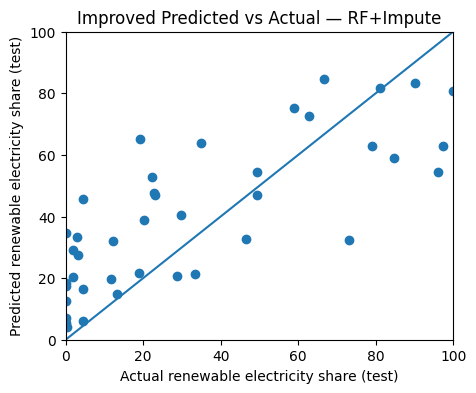

In [22]:
plt.figure(figsize=(5,4))
plt.scatter(y_test, best_pred)
plt.xlabel("Actual renewable electricity share (test)")
plt.ylabel("Predicted renewable electricity share (test)")
plt.title(f"Improved Predicted vs Actual — {best_name}")

lo = min(y_test.min(), best_pred.min())
hi = max(y_test.max(), best_pred.max())
plt.plot([lo, hi], [lo, hi])
plt.xlim(lo, hi)
plt.ylim(lo, hi)

plt.savefig("fig1_pred_vs_actual_improved.png", dpi=160, bbox_inches="tight")
plt.show()

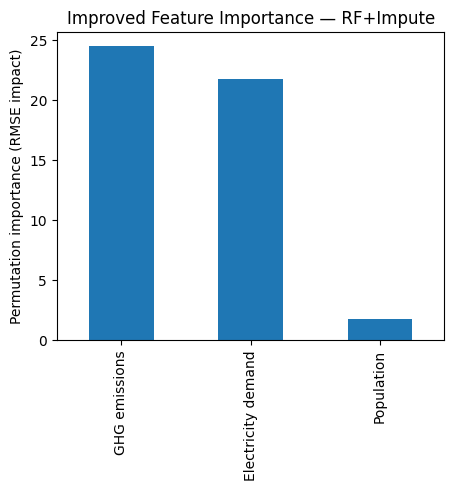

In [23]:
# Compute permutation importance on test set (after preprocessing inside pipeline)
perm = permutation_importance(
    best_model, X_test, y_test,
    n_repeats=20,
    random_state=42,
    scoring="neg_root_mean_squared_error"
)

imp = pd.Series(perm.importances_mean, index=X_improved.columns).sort_values(ascending=False)

plt.figure(figsize=(5,4))
imp.head(12).plot(kind="bar")
plt.ylabel("Permutation importance (RMSE impact)")
plt.title(f"Improved Feature Importance — {best_name}")
plt.savefig("fig2_feature_importance_improved.png", dpi=160, bbox_inches="tight")
plt.show()

In [24]:
summary = pd.DataFrame([{
    "best_model": best_name,
    "test_rmse": best_rmse,
    "test_r2": best_r2
}])
summary.to_csv("improved_metrics.csv", index=False)
summary

,best_model,test_rmse,test_r2
0,RF+Impute,21.878535,0.553481
